In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


def recall_k(k,test,train,res):
    return [np.mean([float(np.intersect1d(res[x][:k],test[test[:,0]==x,1]).size)/test[test[:,0]==x,1].size for x in xrange(res.shape[0])])]

def recall_k_df(k,test,train,res):
    data=[(k,test[test[:,0]==x,1].size,float(np.intersect1d(res[x][:k],test[test[:,0]==x,1]).size)/test[test[:,0]==x,1].size) for x in xrange(res.shape[0])]
    p=pd.DataFrame(data,columns=['m','n_rel_items','recall_m_rel_items'])
    return p
    
def results_k(k,test,res):
        eval_list=[]
        test=test.astype(int)   
        for i in xrange(res.shape[0]):
                relevant = test[test[:,0]==i,1]
                retrieved_k = np.array(sorted(zip(res[i],xrange(res[i].size)),reverse=True))[:k,1].astype(int)
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                eval_list.append([relevant_retrieved.size/float(relevant.size),relevant_retrieved.size/float(k)])
        return np.mean(eval_list,axis=0)
    
def results_k_without_train(k,test,train,res):
        eval_list=[]
        test=test.astype(int)   
        for i in xrange(res.shape[0]):
                relevant = test[test[:,0]==i,1]
                known_items = train[train[:,0]==i,1]
                scores_user_i=np.array(res[i])
                scores_user_i[known_items]=-np.inf
                retrieved_k = scores_user_i.argsort()[::-1][:k]
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                recall_without_train=relevant_retrieved.size/float(relevant.size)
                
                retrieved_k = res[i].argsort()[::-1][:k]
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                recall_with_train=relevant_retrieved.size/float(relevant.size)
                eval_list.append([recall_without_train,recall_with_train])
        return np.mean(eval_list,axis=0)
    
def genGraphRes(folder,res_files):
    test=np.loadtxt(folder+'user_artist_rating.test')
    summary_res=dict()
    for experiment in res_files:
        print "experiment: "+experiment
        res=np.loadtxt(folder+experiment)
        exps=np.vstack((np.hstack((results_k(M,test,res),[M])) for M in [50, 100, 150, 200, 250]))
        p=pd.DataFrame(exps,columns=['recall_at_m','precision_at_m','m'])
        p.plot(x='m')
        plt.show()
        summary_res[experiment]=p
    return summary_res

def genGraphRes_recall(folder,res_files):
    test=np.loadtxt(folder+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder+'user_artist_rating.train').astype(int)
    summary_res=dict()
    for experiment in res_files:
        print "experiment: "+experiment
        res=np.loadtxt(folder+experiment)
        exps=np.vstack((np.hstack((results_k_without_train(M,test,train,res),[M])) for M in [50, 100, 150, 200, 250]))
        p=pd.DataFrame(exps,columns=['recall_at_m (filter_train)','precision_at_m','m'])
        p.plot(x='m')
        plt.show()
        summary_res[experiment]=p
    return summary_res

def genGraphRes_recall_resrec(folder_dataset,res_files,folder_result=None,m_vals=[50, 100, 150, 200, 250],is_plot=True):
    if(folder_result==None):
        folder_result=folder_dataset
    print "dataset folder: ",folder_dataset
    test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
    summary_res=dict()
    list_res=[]
    for experiment in res_files:
        print "experiment: "+experiment
        print "loading "+folder_result+experiment
        res=np.loadtxt(folder_result+experiment)
        exps=np.vstack((np.hstack((recall_k(M,test,train,res),[M])) for M in m_vals))
        p=pd.DataFrame(exps,columns=['recall_at_m (filter_train)','m'])
        if(is_plot):
            p.plot(x='m')
            plt.show()
        summary_res[experiment]=p
    return summary_res


def genGraphRes_recall_folders(res_files,m_vals=[50, 100, 150, 200, 250],is_plot=True,log_print=True):
    
    summary_res=dict()
    list_res=[]
    for experiment in res_files:
        
        folder_dataset = experiment.split("experiment_")[0]
        if(log_print):
            "dataset folder: ",folder_dataset
        test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
        train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
        if(log_print):
            print "experiment: "+experiment.split("experiment_")[1]
            print "loading "+experiment
        res=np.loadtxt(experiment)
        exps=np.vstack((np.hstack((recall_k(M,test,train,res),[M])) for M in m_vals))
        p=pd.DataFrame(exps,columns=['recall_at_m (filter_train)','m'])
        if(is_plot):
            p.plot(x='m')
            plt.show()
        summary_res[folder_dataset.split('/')[-2]+"_"+experiment.split("experiment_")[1]]=p
    return summary_res


def recall_folders_single(experiment,m_vals=[50, 100, 150, 200, 250],log_print=True):
    
    list_res=[]
    m_str=['recall_m'+str(m) for m in m_vals]
    folder_dataset = experiment.split("experiment_")[0]
    if(log_print):
        "dataset folder: ",folder_dataset
    test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
    if(log_print):
        print "experiment: "+experiment.split("experiment_")[1]
        print "loading "+experiment
    res=np.loadtxt(experiment)
    exps=zip(m_str,[recall_k(M,test,train,res) for M in m_vals])
    return exps

baseline_pd=pd.DataFrame()
baseline_pd['CTR-SMF']=[0.17,0.28,0.36,0.435,0.48]
baseline_pd['CTR']=[0.165,0.26,0.34,0.41,0.46]
baseline_pd['PMF']=[0.16,0.25,0.33,0.4,0.45]
def plotCompare(datax,baseline_vals,name='PoissonTopicSocial'):
    dataf=pd.DataFrame()
    dataf[name]=datax['recall_at_m (filter_train)']
    dataf['m']=datax['m']
    dataf['CTR-SMF']=baseline_vals['CTR-SMF']
    dataf['CTR']=baseline_vals['CTR']
    dataf['PMF']=baseline_vals['PMF']
    dataf.plot(x='m')
    plt.show()
    return dataf

def plotListCompare(datax,baseline_vals,names,threshold=0.47,do_plot=True,log_print=True):
    dataf=pd.DataFrame()
    dataf['CTR-SMF']=baseline_vals['CTR-SMF']
    dataf['CTR']=baseline_vals['CTR']
    dataf['PMF']=baseline_vals['PMF']
    for key in datax:
        if np.array(datax[key][datax[key].m==250]['recall_at_m (filter_train)']>threshold)[0]:
            if(log_print):
                print "file=",key,"id=",names[key]
            dataf[names[key]]=datax[key]['recall_at_m (filter_train)']
            dataf['m']=datax[key]['m']
    if(do_plot):
        plt.figure(figsize=(200,200))
        dataf.plot(x='m',linestyle='-', marker='x')
        #plt.show()
        plt.savefig('/home/eliezer/plot_out.png')
    return dataf

def load_test_train(folder='/home/eliezer/datasets/hetrec2011/lastfm/p85_train_test_9208/'):
    test=np.loadtxt(folder+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder+'user_artist_rating.train').astype(int)
    return (test,train)

In [168]:
#folder='/home/eliezer/datasets/hetrec2011/lastfm/p85_train_test_9208/'
#res_files = !ls long_experiments/experiment_w*.rec
#summary_long=genGraphRes_recall_resrec(folder,res_files,is_plot=False)

#cmp_data2=plotListCompare(summary_long_laptop,baseline_pd,idnames_lap,threshold=0.45)
def plotall_summary_dataf(summary_long,kcol_str,boxplot=False):
    data_cmp5=plotListCompare(summary_long,baseline_pd,\
                         dict(zip(summary_long.keys(),\
                                  [x.split("_")[5]+'_'+x.split("_")[3] for x in summary_long.keys()])),\
                         0.3,log_print=False,do_plot=False)
    data_cmp5['k_err']=data_cmp5[[x for x in data_cmp5.columns if x.startswith(kcol_str)]].std(axis=1)
    data_cmp5['PoissonMF-CS']=data_cmp5[[x for x in data_cmp5.columns if x.startswith(kcol_str)]].mean(axis=1)
    plotErrorBar_data_cmp(data_cmp5,boxplot)
    return data_cmp5

#cmp_data2=plotListCompare(summary_long_laptop,baseline_pd,idnames_lap,threshold=0.45)
def plotall_summary_dataf_vark(summary_long,lstK,suffix_str):
    data_cmp=plotListCompare(summary_long,baseline_pd,\
                         dict(zip(summary_long.keys(),\
                                  [suffix_str+str(x) for x in lstK])),\
                         0.3,log_print=False,do_plot=False)
    newfrm=data_cmp[[suffix_str+str(x) for x in lstK]]
    newfrm.index = data_cmp['m']
    axs=newfrm.plot(linestyle='-', marker='p')
    return data_cmp

def plotErrorBar_data_cmp(data_cmp,boxplot=False):
    matplotlib.rc('text', usetex=False)
    data_cmp['m']=data_cmp['m'].astype(int)
    newfrm=data_cmp[['PoissonMF-CS','CTR-SMF', 'CTR', 'PMF']]
    x=data_cmp['m']
    ma = data_cmp['PoissonMF-CS'].values
    mstd = data_cmp['k_err']
    plt.figure()
    if(boxplot):
        x=data_cmp['m'].index+1
    newfrm.index = x
    axs=newfrm.plot(linestyle='-', marker='p')
    axs.set_xlabel('# returned items ($M$)')
    axs.set_ylabel('Avg. recall@$M$')
    if(boxplot):
        temp=data_cmp[[x for x in data_cmp.columns if x.startswith('k')]]
        temp['m']=data_cmp['m']
        res_dic=temp.pivot_table(cols=['m']).boxplot(ax=axs)
    else:
        plt.fill_between(x, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
    x1,x2,y1,y2 = plt.axis()

    plt.axis((x1,x2,.15,.55))
    

In [3]:
exp2_files=!./get_entity_log.sh long_experiment2_p85_834 "##latent_var_file" "##results_file"
exp2_files=[x.split("|") for x in exp2_files]
exp2_files=pd.DataFrame(exp2_files, columns=['latent_vars','rec'])
exp2_files.rec.tolist()
summary_long=genGraphRes_recall_folders(exp2_files.rec.tolist(),is_plot=False,log_print=False)
data_cmp=plotListCompare(summary_long,baseline_pd,\
                dict(zip(summary_long.keys(),[x.split("_")[1] for x in summary_long.keys()])),\
                0.4,log_print=False,do_plot=False)

In [44]:
data_cmp['m'].index+1

Int64Index([1, 2, 3, 4, 5], dtype='int64')

In [4]:
exp2_files=!./get_entity_log.sh long_experiment3_fixedk100_learnw_p85 "##latent_var_file" "##results_file"
exp2_files=[x.split("|") for x in exp2_files]
exp2_files=pd.DataFrame(exp2_files, columns=['latent_vars','rec'])
exp2_files.rec.tolist()
summary_long=genGraphRes_recall_folders(exp2_files.rec.tolist(),is_plot=False,log_print=False)

In [175]:
len(exp2_files)

33

In [5]:
summary_long.keys()
# generate table comparing with state of the art
data_cmp=plotListCompare(summary_long,baseline_pd,\
                         dict(zip(summary_long.keys(),\
                                  [x.split("_")[5]+'_'+x.split("_")[3] for x in summary_long.keys()])),\
                         0.3,log_print=False,do_plot=False)

data_cmp['k_err']=data_cmp[[x for x in data_cmp.columns if x.startswith('k100')]].std(axis=1,\
                                                                                      ddof=len(\
                                                                                    [x for x in data_cmp.columns \
                                                                                     if x.startswith('k100')])-1)
data_cmp['k_err']=data_cmp[[x for x in data_cmp.columns if x.startswith('k100')]].std(axis=1)
data_cmp['PoissonMF-CS']=data_cmp[[x for x in data_cmp.columns if x.startswith('k100')]].mean(axis=1)

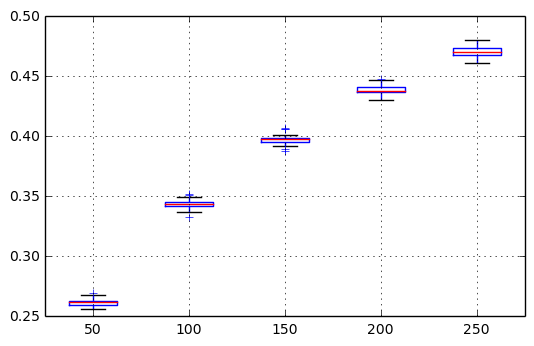

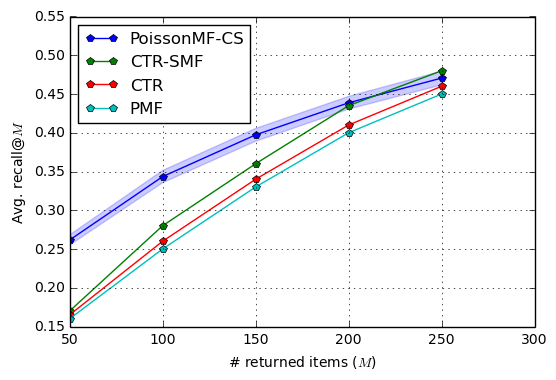

In [158]:
plt.figure()
temp=data_cmp[[x for x in data_cmp.columns if x.startswith('k100')]]
temp['m']=data_cmp['m'].astype(int)
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment3_fixedk100_learnw_p85_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp)
plt.savefig('experiment3_fixedk100_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')


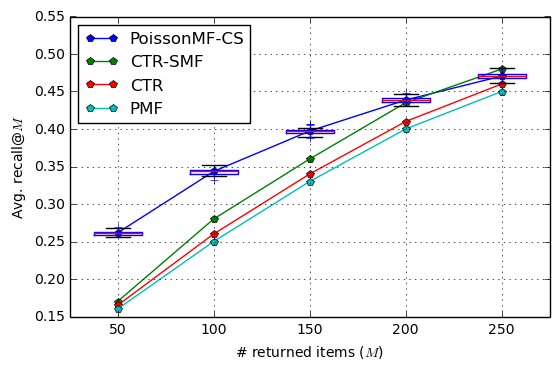

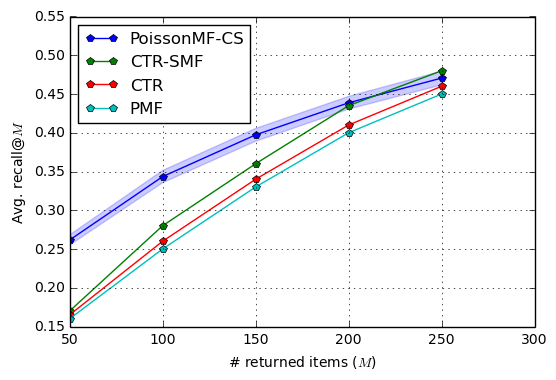

In [159]:
plt.figure()
data_cmp['m']=data_cmp['m'].astype(int)

plotErrorBar_data_cmp(data_cmp,boxplot=True)
plt.savefig('experiment3_fixedk100_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

plotErrorBar_data_cmp(data_cmp,boxplot=False)

,CTR-SMF,CTR,PMF,k100_4052,m,k100_800,k100_9417,k100_9059,k100_4682,k100_4508,k100_3400,k100_2623,k100_7230,k100_7559,k100_7955,k100_2245,k100_3330,k100_4671,k100_7762,k100_4563,
0,0.170,0.165,0.16,0.261857,50,0.267680,0.266288,0.262949,0.266896,0.262421,0.260254,0.273908,0.261839,0.271714,0.266772,0.271106,0.270340,0.267424,0.269961,0.261461,...
1,0.280,0.260,0.25,0.344186,100,0.349885,0.354413,0.349560,0.348370,0.346239,0.343323,0.354915,0.347216,0.355418,0.354598,0.351031,0.351727,0.352722,0.351630,0.346899,...
2,0.360,0.340,0.33,0.394626,150,0.399234,0.407012,0.404704,0.400185,0.400890,0.399313,0.412773,0.400132,0.408580,0.404360,0.403823,0.405171,0.406757,0.407778,0.402008,...
3,0.435,0.410,0.40,0.437544,200,0.440795,0.447763,0.448018,0.441517,0.444177,0.441411,0.453127,0.444468,0.448555,0.451268,0.445860,0.447322,0.443966,0.449850,0.440724,...
4,0.480,0.460,0.45,0.470780,250,0.474806,0.481906,0.478532,0.475079,0.474154,0.471564,0.487033,0.477678,0.478894,0.481871,0.476163,0.480620,0.477819,0.481210,0.472225,...


In [167]:
exp3_files=!./get_entity_log.sh long_experiment3_fixedk100_learnw_p90 "##latent_var_file" "##results_file"
exp3_files=[x.split("|") for x in exp3_files]
exp3_files=pd.DataFrame(exp3_files, columns=['latent_vars','rec'])
exp3_files.rec.tolist()
summary_long2=genGraphRes_recall_folders(exp3_files.rec.tolist(),is_plot=False,log_print=False)

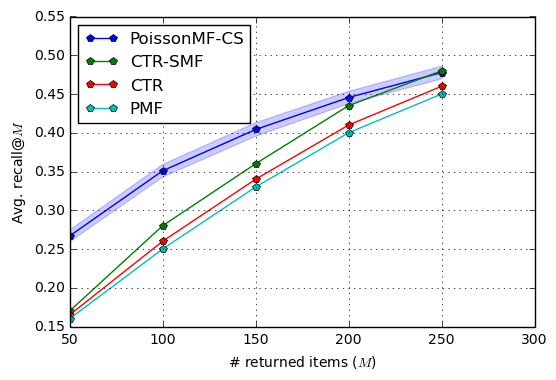

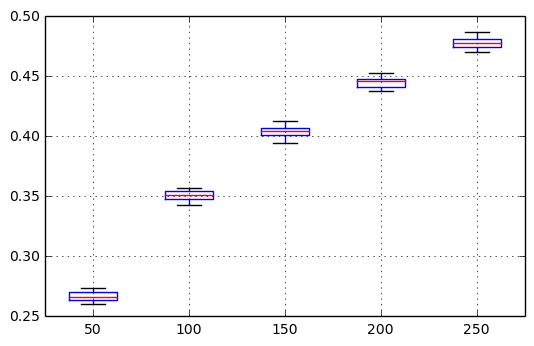

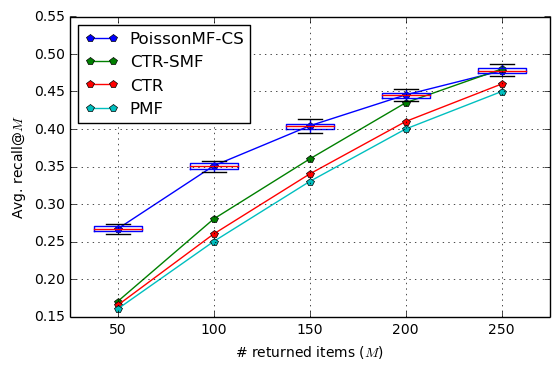

In [170]:
# generate table comparing with state of the art
plt.figure()
data_cmp2=plotall_summary_dataf(summary_long2,'k100')
plt.savefig('experiment3_fixedk100_learnw_p90_varM_shaded_cmp.pdf', bbox_inches='tight')


plt.figure()
temp=data_cmp2[[x for x in data_cmp2.columns if x.startswith('k100')]]
temp['m']=data_cmp['m'].astype(int)
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment3_fixedk100_learnw_p90_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp2,boxplot=True)
plt.savefig('experiment3_fixedk100_learnw_p90_varM_boxp_cmp.pdf', bbox_inches='tight')


In [10]:
data_cmp[['CTR-SMF', 'CTR', 'PMF', 'PoissonMF-CS','k_err']]


,CTR-SMF,CTR,PMF,PoissonMF-CS,k_err
0,0.170,0.165,0.16,0.261583,0.003295
1,0.280,0.260,0.25,0.343404,0.003957
2,0.360,0.340,0.33,0.397277,0.004136
3,0.435,0.410,0.40,0.438667,0.004114
4,0.480,0.460,0.45,0.470556,0.004425


In [11]:
data_cmp2[['CTR-SMF', 'CTR', 'PMF', 'PoissonMF-CS','k_err']]

,CTR-SMF,CTR,PMF,PoissonMF-CS,k_err
0,0.170,0.165,0.16,0.266826,0.003796
1,0.280,0.260,0.25,0.350885,0.004064
2,0.360,0.340,0.33,0.404216,0.004337
3,0.435,0.410,0.40,0.445472,0.003968
4,0.480,0.460,0.45,0.477665,0.004058


In [12]:
# collect values for exp4
exp4_files=!./get_entity_log.sh long_experiment4_fixedk50_learnw_p85 "##latent_var_file" "##results_file"
exp4_files=[x.split("|") for x in exp4_files]
exp4_files=pd.DataFrame(exp4_files, columns=['latent_vars','rec'])
exp4_files.rec.tolist()
summary_long3=genGraphRes_recall_folders(exp4_files.rec.tolist(),is_plot=False,log_print=False)

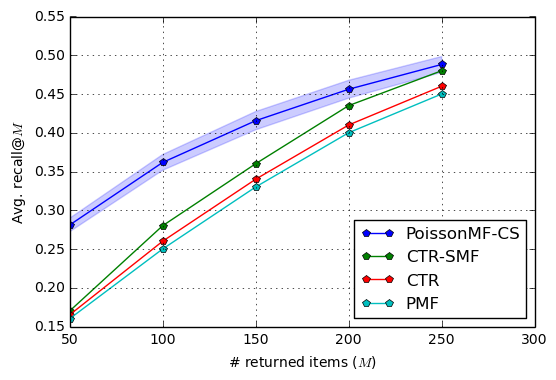

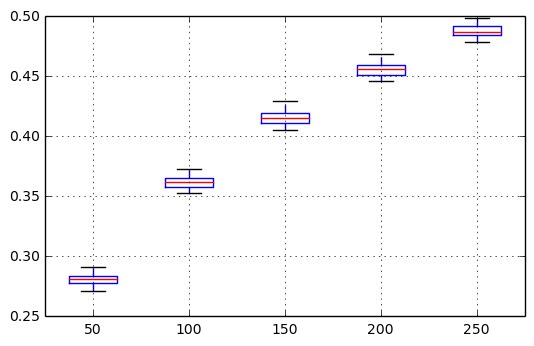

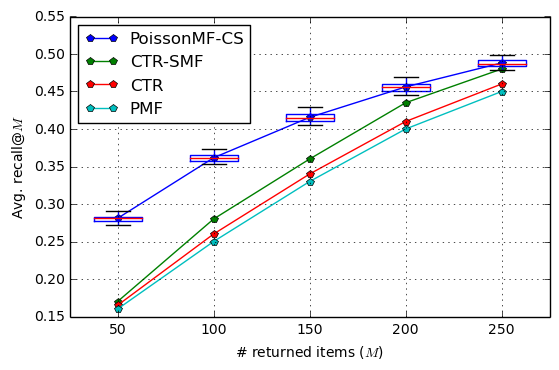

In [171]:
# generate table comparing with state of the art
plt.figure()
data_cmp3=plotall_summary_dataf(summary_long3,'k50')
plt.savefig('experiment4_fixedk50_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')

plt.figure()
temp=data_cmp3[[x for x in data_cmp3.columns if x.startswith('k50')]]
temp['m']=data_cmp3['m']
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment4_fixedk50_learnw_p85_varM_boxp.pdf', bbox_inches='tight')


plt.figure()
plotErrorBar_data_cmp(data_cmp3,boxplot=True)
plt.savefig('experiment4_fixedk50_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

In [14]:
tempa=!./get_entity_log.sh long_experiment5_fixedk5_learnw_p85 "##latent_var_file" "##results_file"

tempb=!./get_entity_log.sh long_experiment3_fixedk15_learnw_p85 "##latent_var_file" "##results_file"
print len(tempa)
print len(tempb)

30
15


In [15]:
# collect values for exp5
exp5_files=!./get_entity_log.sh long_experiment3_fixedk15_learnw_p85 "##latent_var_file" "##results_file"
exp5_files=[x.split("|") for x in exp5_files]
exp5_files=pd.DataFrame(exp5_files, columns=['latent_vars','rec'])
exp5_files.rec.tolist()
summary_long5=genGraphRes_recall_folders(exp5_files.rec.tolist(),is_plot=False,log_print=False)

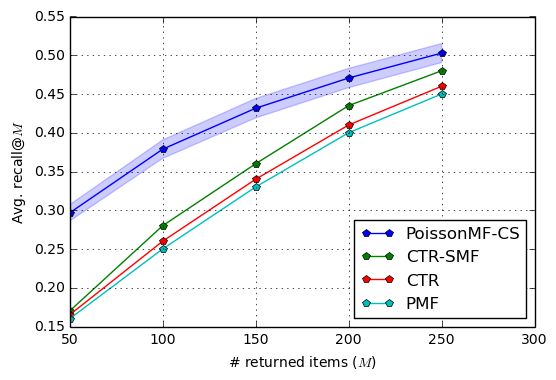

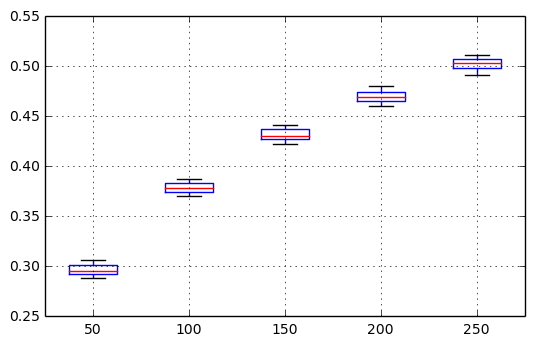

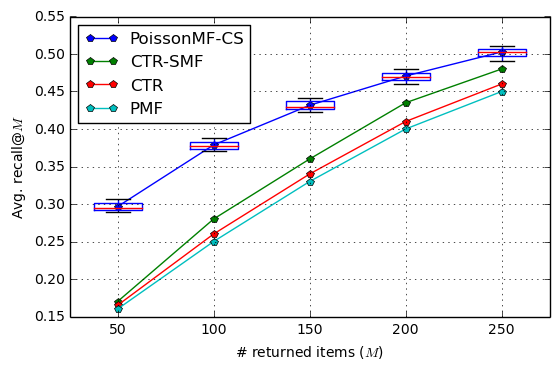

In [172]:
# generate table comparing with state of the art
plt.figure()
data_cmp5=plotall_summary_dataf(summary_long5,'k15')
plt.savefig('experiment3_fixedk15_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')


plt.figure()
temp=data_cmp5[[x for x in data_cmp5.columns if x.startswith('k15')]]
temp['m']=data_cmp5['m']
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment3_fixedk15_learnw_p85_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp5,boxplot=True)
plt.savefig('experiment3_fixedk15_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

In [17]:
# collect values for exp5
exp6_files=!./get_entity_log.sh long_experiment5_fixedk5_learnw_p85 "##latent_var_file" "##results_file"
exp6_files=pd.DataFrame([x.split("|") for x in exp6_files], columns=['latent_vars','rec'])
exp6_files.rec.tolist()
summary_long6=genGraphRes_recall_folders(exp6_files.rec.tolist(),is_plot=False,log_print=False)

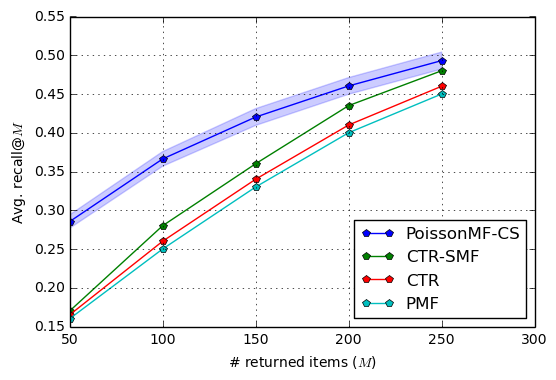

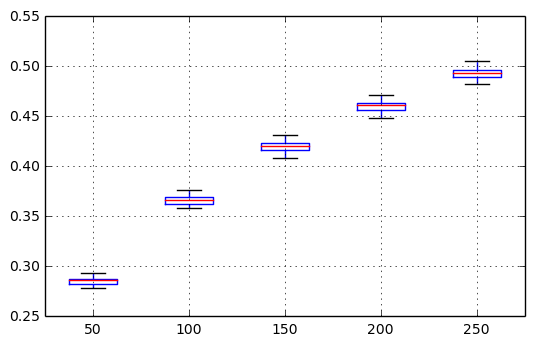

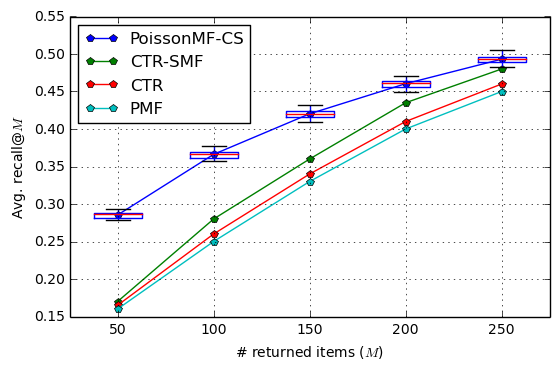

In [173]:
plt.figure()
data_cmp6=plotall_summary_dataf(summary_long6,'k5')
plt.savefig('experiment5_fixedk5_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')

ax=plt.figure()
temp=data_cmp6[[x for x in data_cmp6.columns if x.startswith('k5')]]
temp['m']=data_cmp6['m']
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment5_fixedk5_learnw_p85_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp6,boxplot=True)
plt.savefig('experiment5_fixedk5_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

In [20]:
# collect values for exp5
exp8_files=!./get_entity_log.sh long_experiment7_fixedk10_learnw_p85 "##latent_var_file" "##results_file"
exp8_files=pd.DataFrame([x.split("|") for x in exp8_files], columns=['latent_vars','rec'])
exp8_files.rec.tolist()
summary_long8=genGraphRes_recall_folders(exp8_files.rec.tolist(),is_plot=False,log_print=False)

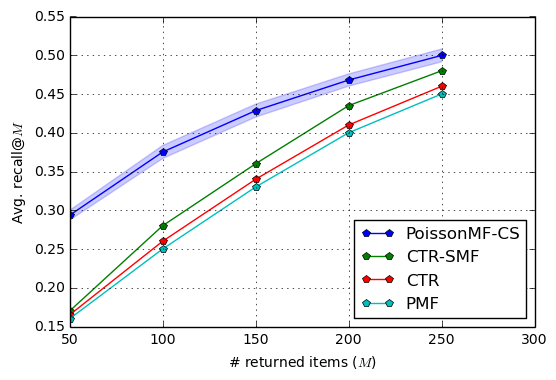

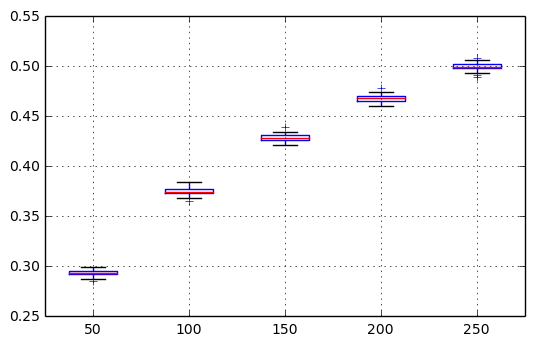

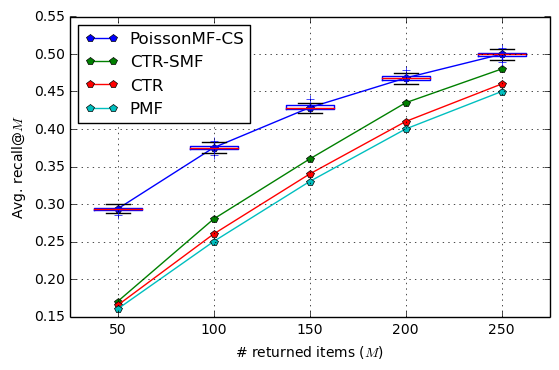

In [174]:
plt.figure()
data_cmp8=plotall_summary_dataf(summary_long8,'k10')
plt.savefig('experiment7_fixedk10_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')

ax=plt.figure()
temp=data_cmp8[[x for x in data_cmp8.columns if x.startswith('k10')]]
temp['m']=data_cmp8['m']
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment7_fixedk10_learnw_p85_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp8,boxplot=True)
plt.savefig('experiment7_fixedk10_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

In [22]:
exp9_files=!./get_entity_log.sh long_experiment8_fixedk20_learnw_p85 "##latent_var_file" "##results_file"
exp9_files=pd.DataFrame([x.split("|") for x in exp9_files], columns=['latent_vars','rec'])
exp9_files.rec.tolist()
summary_long9=genGraphRes_recall_folders(exp9_files.rec.tolist(),is_plot=False,log_print=False)

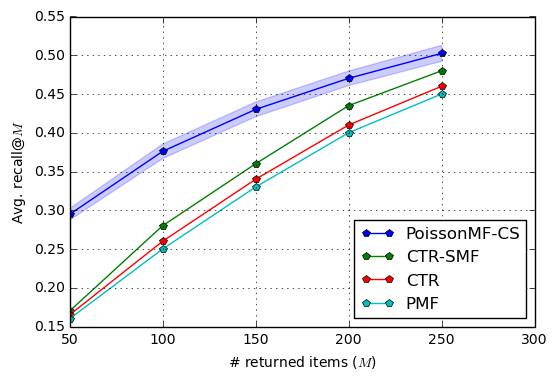

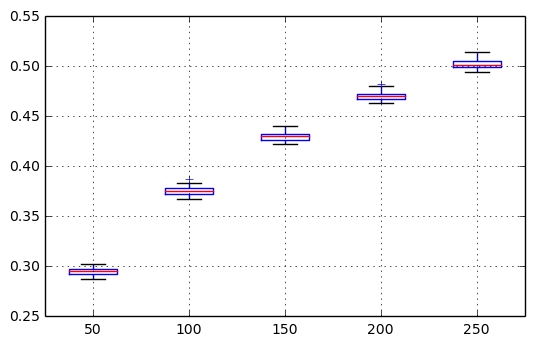

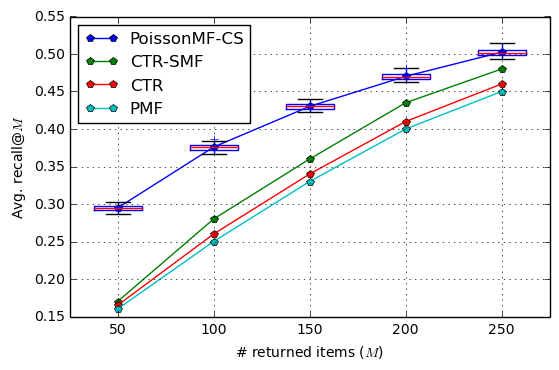

In [175]:
plt.figure()
data_cmp9=plotall_summary_dataf(summary_long9,'k20')
plt.savefig('experiment8_fixedk20_learnw_p85_varM_shaded_cmp.pdf', bbox_inches='tight')

ax=plt.figure()
temp=data_cmp9[[x for x in data_cmp9.columns if x.startswith('k20')]]
temp['m']=data_cmp9['m']
x=temp.pivot_table(cols=['m']).boxplot()
plt.savefig('experiment8_fixedk20_learnw_p85_varM_boxp.pdf', bbox_inches='tight')

plt.figure()
plotErrorBar_data_cmp(data_cmp9,boxplot=True)
plt.savefig('experiment8_fixedk20_learnw_p85_varM_boxp_cmp.pdf', bbox_inches='tight')

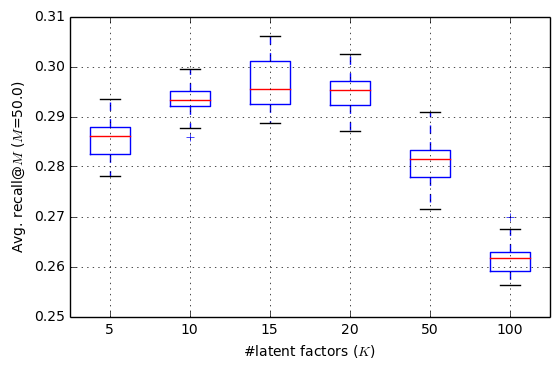

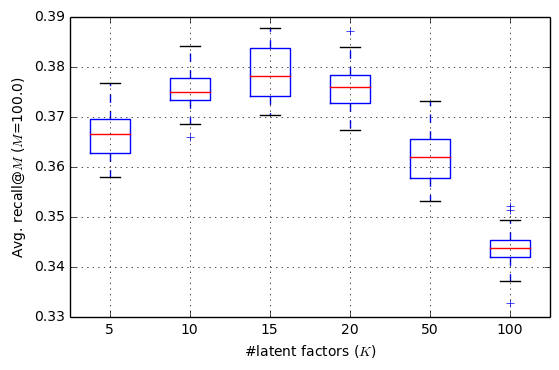

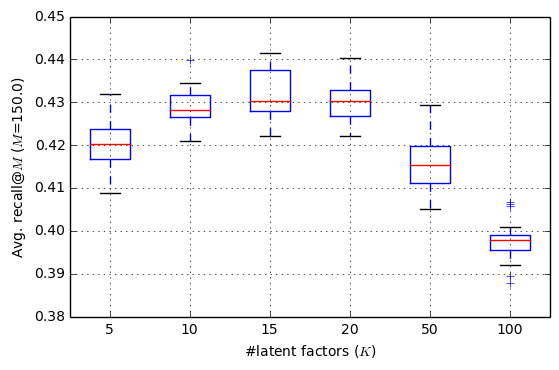

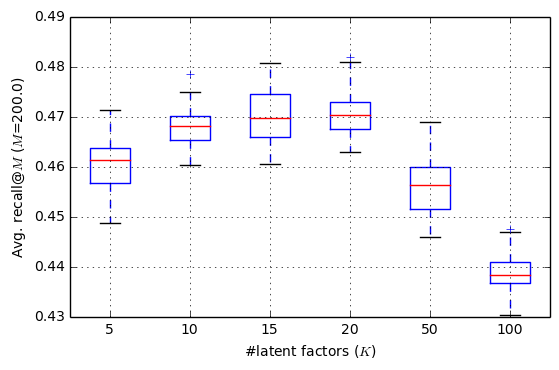

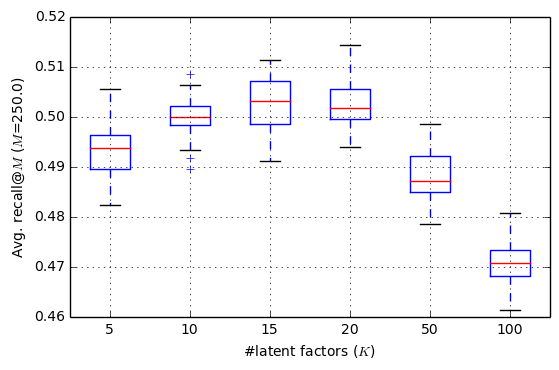

In [35]:
### compare parameter k across multiple runs of the experiments at different recall@m

def processColChangeName(data_cmp,m):
    temp=data_cmp[data_cmp['m']==m][[x for x in data_cmp.columns if x.startswith('k') and len(x.split('_')[0])>1]]
    k=int(temp.columns[0].split('_')[0].replace('k',''))
    temp=temp.rename(columns=dict(zip(temp.columns,[x.split('_')[1] for x in temp.columns])))
    temp['k']=k
    return temp

def cmp_k_recall_boxp(m,lst_df=[data_cmp,data_cmp3,data_cmp5,data_cmp6,data_cmp8,data_cmp9]):
    temp=None
    startloop=True
    for df in [data_cmp,data_cmp3,data_cmp5,data_cmp6,data_cmp8,data_cmp9]:
        if(startloop):
            temp=processColChangeName(df,m)
            startloop=False
        else:
            temp=temp.append(processColChangeName(df,m))
    axs=plt.subplot(111)
    #plt.title("m="+str(m))
    axs.set_xlabel('#latent factors ($K$)')
    axs.set_ylabel('Avg. recall@$M$ ($M$='+str(m)+')')
    x=temp.pivot_table(cols=['k']).boxplot()
    return (x,temp.pivot_table(cols=['k']))


startloop=True
for m in data_cmp['m'].values:
    if(startloop):
        plt.figure()
        x,y=cmp_k_recall_boxp(m)
        z_temp=pd.DataFrame(y.mean())
        z_temp.index=y.mean().index.values
        z_temp.index=[(x,m) for x in z_temp.index]
        z=z_temp

        z_temp2=pd.DataFrame()
        z_temp2=z_temp2.append(z_temp)
        z_temp2[0]=z_temp[0].values-np.min(z_temp[0].values)
        z2=z_temp2
        startloop=False
    else:
        plt.figure()
        x,y=cmp_k_recall_boxp(m)
        z_temp=pd.DataFrame(y.mean())
        z_temp.index=y.mean().index.values
        z_temp.index=[(x,m) for x in z_temp.index]
        z=z.append(z_temp)

        z_temp2=pd.DataFrame(z_temp)
        z_temp2[0]=z_temp[0].values-np.min(z_temp[0].values)
        z2=z2.append(z_temp2)
    plt.savefig('experimentmany_vark_learnw_p85_m'+str(int(m))+'_boxp_cmp.pdf', bbox_inches='tight')







l="""
plt.figure()
x,y=cmp_k_recall_boxp(data_cmp['m'].values[2])
z_temp=pd.DataFrame(y.mean())
z_temp.index=y.mean().index.values
z_temp.index=[(x,data_cmp['m'].values[2]) for x in z_temp.index]
z=z.append(z_temp)

z_temp2=pd.DataFrame(z_temp)
z_temp2[0]=z_temp[0].values-np.min(z_temp[0].values)
z2=z2.append(z_temp2)


plt.figure()
x,y=cmp_k_recall_boxp(data_cmp['m'].values[3])
z_temp=pd.DataFrame(y.mean())
z_temp.index=y.mean().index.values
z_temp.index=[(x,data_cmp['m'].values[3]) for x in z_temp.index]
z=z.append(z_temp)

z_temp2=pd.DataFrame(z_temp)
z_temp2[0]=z_temp[0].values-np.min(z_temp[0].values)
z2=z2.append(z_temp2)


plt.figure()
x,y=cmp_k_recall_boxp(data_cmp['m'].values[4])
z_temp=pd.DataFrame(y.mean())
z_temp.index=y.mean().index.values
z_temp.index=[(x,data_cmp['m'].values[4]) for x in z_temp.index]
z=z.append(z_temp)

z_temp2=pd.DataFrame(z_temp)
z_temp2[0]=z_temp[0].values-np.min(z_temp[0].values)
z2=z2.append(z_temp2)

"""

In [36]:
fxy=np.array(list(z.index))
fz=z[0].values
fk=fxy[:,0]
fm=fxy[:,1]


In [37]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


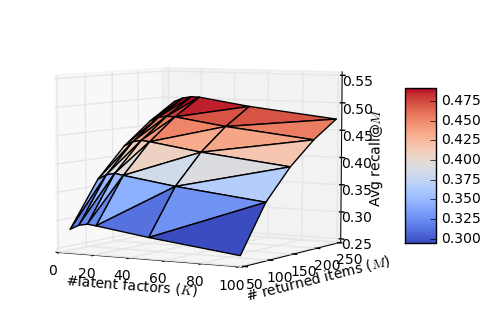

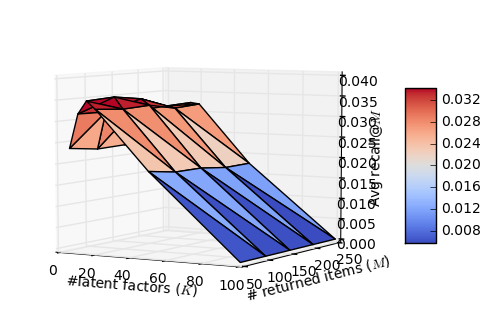

In [39]:


import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_trisurf(fk, fm, z[0].values,cmap=cm.coolwarm)

ax.view_init(elev=6, azim=300)

ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('# returned items ($M$)')
ax.set_zlabel('Avg recall@$M$')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('experimentmany_vark_learnw_p85_varm_3dsurf_cmp.pdf', bbox_inches='tight')

plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf=ax.plot_trisurf(fk, fm, z2[0].values,cmap=cm.coolwarm)

ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('# returned items ($M$)')
ax.set_zlabel('Avg recall@$M$')
ax.view_init(elev=6, azim=300)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('experimentmany_vark_learnw_p85_varm_3dsurf_difftop_cmp.pdf', bbox_inches='tight')

plt.show()


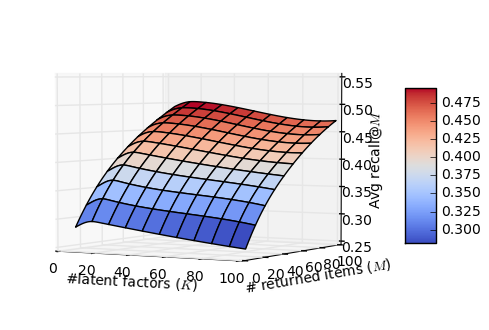

In [40]:
from scipy import interpolate
f=interpolate.interp2d(fk, fm, z[0].values, kind='cubic')

Xnew = np.linspace(np.min(fk),np.max(fk),100)
Ynew = np.linspace(np.min(fm),np.max(fm),100)

Znew = f(Xnew,Ynew)
#Znew=Znew.reshape((100*100))
x,y=np.meshgrid(Xnew,Xnew)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(x,y,Znew,cmap=cm.coolwarm)

ax.view_init(elev=3, azim=300)

ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('# returned items ($M$)')
ax.set_zlabel('Avg recall@$M$')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('experimentmany_vark_learnw_p85_varm_3dsurf_interp_cmp.pdf', bbox_inches='tight')

plt.show()


8.8383838383838373

In [41]:
def plotCompareSameExpErrorBar_data_cmp(data_cmp_lst,legends=None):
    plt.figure()
    c=0
    for data_cmp in data_cmp_lst:
        x = data_cmp['m']
        ma = data_cmp['PoissonMF-CS'].values
        mstd = data_cmp['k_err']
        strlabel='exp '+str(c) if legends == None else legends[c]
        plt.plot(x,ma,linestyle='-',label=strlabel, marker='p')
        plt.fill_between(x, ma-mstd, ma+mstd,alpha=0.2)
        c+=1
    plt.legend(loc=0)

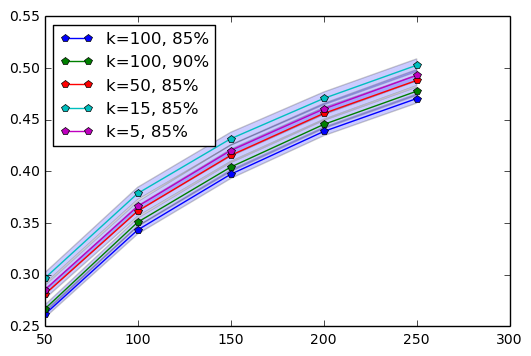

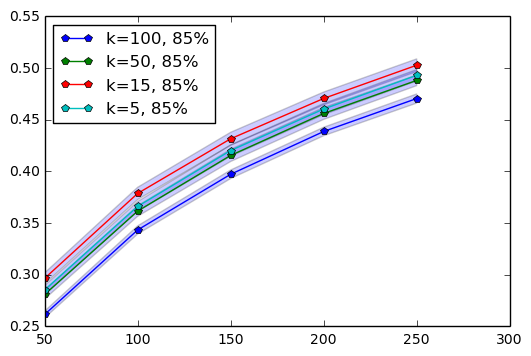

In [42]:
plotCompareSameExpErrorBar_data_cmp([data_cmp,data_cmp2,data_cmp3,data_cmp5,data_cmp6]\
                                   ,["k=100, 85%","k=100, 90%","k=50, 85%","k=15, 85%","k=5, 85%"])

plt.figure()
plotCompareSameExpErrorBar_data_cmp([data_cmp,data_cmp3,data_cmp5,data_cmp6]\
                                   ,["k=100, 85%","k=50, 85%","k=15, 85%","k=5, 85%"])
plt.savefig('many_exp_varK_varM_shaded.pdf', bbox_inches='tight')


In [43]:
exp4_files=!./get_entity_log.sh long_experiment4_fixedk50_learnw_p85 "##results_file" "#time"
exp4_time=pd.DataFrame([[x.split("|")[0],int(x.split("|")[1].split(" ")[0])] \
                        for x in exp4_files],columns=['rec','time'])
print exp4_time["time"].mean()
print exp4_time["time"].std(ddof=1)

4288.54545455
727.911313748


In [44]:
exp4_files=!./get_entity_log.sh long_experiment3_fixedk100_learnw_p85 "##results_file" "#time"
exp4_time=pd.DataFrame([[x.split("|")[0],int(x.split("|")[1].split(" ")[0])] \
                        for x in exp4_files],columns=['rec','time'])
print exp4_time["time"].mean()
print exp4_time["time"].std(ddof=1)

9665.48484848
343.255746603


In [45]:
exp4_files=!./get_entity_log.sh long_experiment5_fixedk5_learnw_p85 "##results_file" "#time"
exp4_time=pd.DataFrame([[x.split("|")[0],int(x.split("|")[1].split(" ")[0])] \
                        for x in exp4_files],columns=['rec','time'])
print exp4_time["time"].mean()
print exp4_time["time"].std(ddof=1)

581.833333333
13.1963509411


In [46]:
exp7_files=!./get_entity_log.sh long_experiment6_fixedd529_vark_learnw_p85 "##results_file" "#time"
fsplit=lambda x:[x.split('|')[0],int(x.split('|')[0].split('k')[1].split('_')[0]),\
                int(x.split('|')[1].split(" ")[0])]
exp7_files=pd.DataFrame([fsplit(x) for x in exp7_files], columns=['rec','k','time(s)'])
print exp7_files
summary_long7=genGraphRes_recall_folders(exp7_files.rec.tolist(),is_plot=False,log_print=False)

                                                 rec    k  time(s)
0  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...    5      495
1  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...   10      790
2  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...   15     1094
3  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...   20     1459
4  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...   25     1809
5  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...   50     3803
6  /home/eliezer/Dropbox/repo-phd/poissoncpp/data...  100     9095

[7 rows x 3 columns]


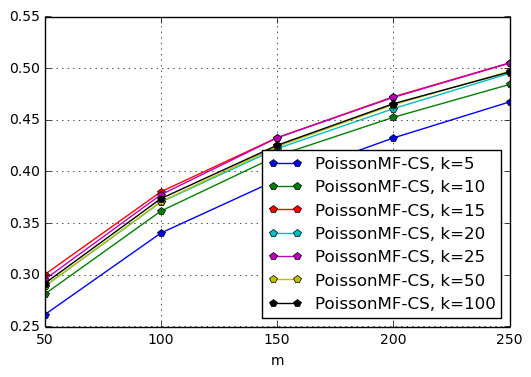

In [47]:
data_cmp7=plotall_summary_dataf_vark(summary_long7,exp7_files.k,"PoissonMF-CS, k=")

In [48]:
def plot_var_k_m(data_cmp7,m,ax=None):
    r_vals=np.array(data_cmp7[data_cmp7['m']==m][[x for x in data_cmp7.columns if x.startswith('PoissonMF-CS')]])
    k_vals=np.array([[int(x.split('=')[1]) for x in data_cmp7.columns if x.startswith('PoissonMF-CS')]])
    data_res=pd.DataFrame(np.hstack((r_vals.T,k_vals.T)),\
             columns=['recall@$M$, $M$='+str(m),'#latent factors ($K$)'])
    if(ax==None):
        ax=data_res.plot(x='#latent factors ($K$)',linestyle='-',marker='p')
    else:
        ax=data_res.plot(x='#latent factors ($K$)',linestyle='-',marker='p',ax=ax)
    return (ax,data_res)

   recall@$M$, $M$=50  #latent factors ($K$)  recall@$M$, $M$=100  \
0            0.261426                      5             0.340481   
1            0.281320                     10             0.361725   
2            0.300260                     15             0.380434   
3            0.288852                     20             0.370424   
4            0.295472                     25             0.377549   
5            0.288962                     50             0.370871   
6            0.291605                    100             0.373779   

   recall@$M$, $M$=150  recall@$M$, $M$=200  recall@$M$, $M$=250  
0             0.392041             0.432496             0.467358  
1             0.415162             0.452468             0.484268  
2             0.432778             0.472292             0.505127  
3             0.422208             0.460809             0.495037  
4             0.432620             0.471754             0.504908  
5             0.424207             0.464671  

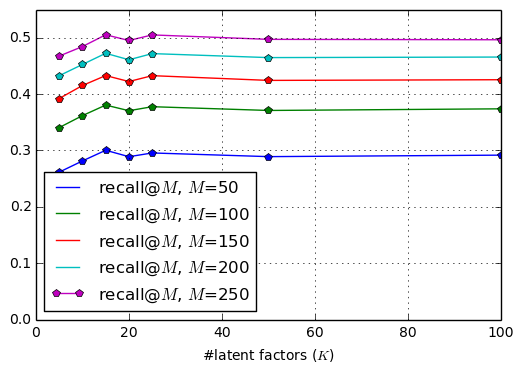

In [49]:
plt.figure()
ax,data_res1=plot_var_k_m(data_cmp7,50)
ax,data_res2=plot_var_k_m(data_cmp7,100,ax)
ax,data_res3=plot_var_k_m(data_cmp7,150,ax)
ax,data_res4=plot_var_k_m(data_cmp7,200,ax)
ax,data_res5=plot_var_k_m(data_cmp7,250,ax)
ax.set_ylim(0.0,0.55)
data_res=data_res1.merge(data_res2).merge(data_res3).merge(data_res4).merge(data_res5)
print data_res
plt.savefig('experiment6_fixedd529_vark_recallat50-250_manylines.pdf', bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


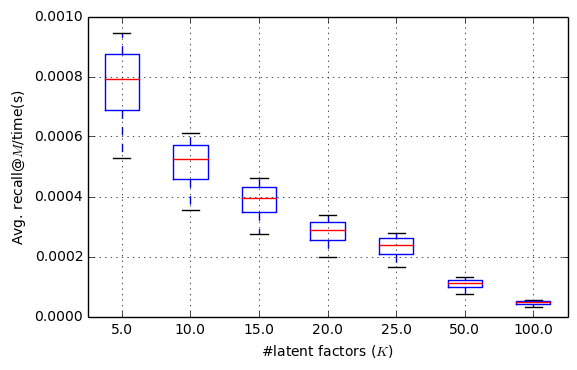

In [52]:
#temppiv=data_res.pivot_table(cols=['#latent factors (k)'])
#temppiv
temppiv=data_res[[x for x in data_res.columns if x.startswith('recall')]]
for x in data_res.columns:
    if x.startswith('recall'):
        temppiv[x]=data_res[x]/exp7_files['time(s)'].astype(float)
temppiv['#latent factors ($K$)']=data_res['#latent factors ($K$)']

fig=plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('Avg. recall@$M$/time(s)')
x=temppiv.pivot_table(cols=['#latent factors ($K$)']).boxplot(ax=ax)


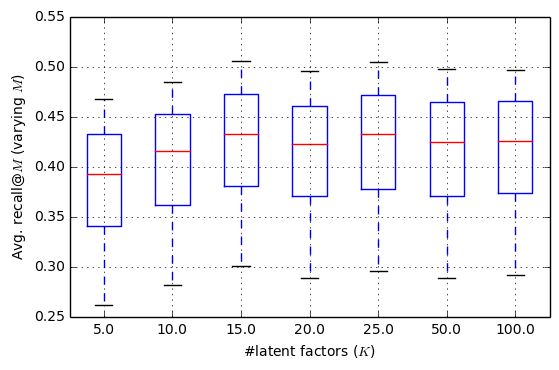

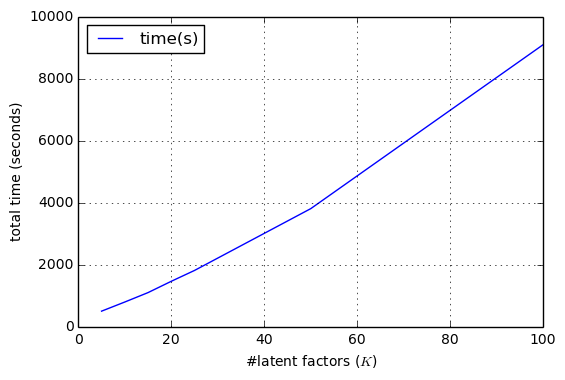

In [54]:
fig=plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('Avg. recall@$M$ (varying $M$)')

x=data_res.pivot_table(cols=['#latent factors ($K$)']).boxplot(ax=ax)
plt.savefig('experiment6_fixedd529_vark_recallat50-250_k.pdf', bbox_inches='tight')

fig=plt.figure()
ax  = fig.add_subplot(111)
exp7_files[['time(s)','k']].plot(x='k',ax=ax)
ax.set_xlabel('#latent factors ($K$)')
ax.set_ylabel('total time (seconds)')
plt.savefig('experiment6_fixedd529_vark_time.pdf', bbox_inches='tight')

In [55]:
print data_cmp3[['PTSMF','k_err']]-data_cmp[['PTSMF','k_err']]
print data_cmp5[['PTSMF','k_err']]-data_cmp3[['PTSMF','k_err']]
print data_cmp6[['PTSMF','k_err']]-data_cmp5[['PTSMF','k_err']]
data_cmp5[['PTSMF','k_err']]

KeyError: "['PTSMF'] not in index"

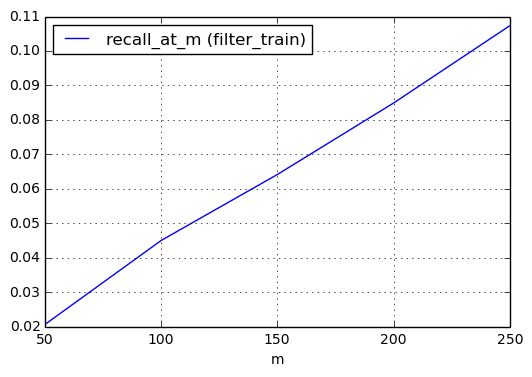

In [56]:
"""completely random recommendations"""

folder='/home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/lastfm/p85_train_test_9208/'
test=np.loadtxt(folder+'user_artist_rating.test').astype(int)
n_users=np.max(test[:,0])+1;
train=np.loadtxt(folder+'user_artist_rating.train').astype(int)
items = np.unique(train[:,1])
res = np.zeros(shape=(n_users,1000))
for i in xrange(n_users):
    res[i,:]=np.random.choice(items, 1000, replace=False)
exps=np.vstack((np.hstack((results_k(M,test,res),[M])) for M in [50, 100, 150, 200, 250]))
p=pd.DataFrame(exps,columns=['recall_at_m (filter_train)','precision_at_m','m'])
p[['recall_at_m (filter_train)','m']].plot(x='m')
plt.show()


In [57]:
matplotlib.rc('text', usetex=False)

def plot3d_summary_var_contw_socw(temp_mean,m=50,fname=None):
    X=temp_mean.contw.values.astype(float)
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    surf=ax.plot_trisurf(X,Y,Z,cmap=cm.coolwarm)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    #ax.view_init(elev=6, azim=300)

    #ax.set_xlabel('#latent factors (k)')
    #ax.set_ylabel('# returned items (m)')
    #ax.set_zlabel('Avg recall@m')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

    plt.show()

def plot3d_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.000000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.plot_trisurf(X,Y,Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        
        
def plot3dcontour_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.000000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.tricontour(X,Y,Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        
    
        
        

        
        
def plot3dscatter_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.00000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.scatter3D(X,Y,Z,c=Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        
def plot3dscatter_summary_rotate(temp_mean,cols,angle=50,elev1=6,fname=None):
    X=temp_mean[cols[0]].values.astype(float)
    Y=temp_mean[cols[1]].values.astype(float)
    Z=temp_mean[cols[2]].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    surf=ax.scatter3D(X,Y,Z,c=Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

def plothexbin_summary_var_contw_socw(temp_mean,m=250,gridsize=4,fname=None):
    X=temp_mean.contw.values.astype(float)+0.0000000001
    Y=temp_mean.socw.values.astype(float)+0.0000000001
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hexbin(X, Y, C=Z,yscale='log',xscale='log',gridsize=gridsize, cmap=cm.jet, bins=None)
    #plt.hexbin(X, Y, C=Z,gridsize=gridsize, cmap=cm.jet)
    plt.axis([X.min(), X.max(), Y.min(), Y.max()])
    cb = plt.colorbar()
    cb.set_label('Avg recall at '+str(m))
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
    
def plothexbin_summary_cols(temp_mean,cols,gridsize=4,fname=None):
    X=temp_mean[cols[0]].values.astype(float)+0.0000000001
    Y=temp_mean[cols[1]].values.astype(float)+0.0000000001
    Z=temp_mean[cols[2]].values

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hexbin(X, Y, C=Z,yscale='log',xscale='log',gridsize=gridsize, cmap=cm.jet, bins=None)
    #plt.hexbin(X, Y, C=Z,gridsize=gridsize, cmap=cm.jet)
    plt.axis([X.min(), X.max(), Y.min(), Y.max()])
    cb = plt.colorbar()
    cb.set_label(cols[2])
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [58]:
exp11_files=!./get_entity_log.sh long_experiment10_fixedk15_constw_varlambda_5datasets_p85 "##results_file" "#time"
exp11_files=[[x.split("|")[0],float(x.split("|")[0].split('contw')[1].split('_')[0]),\
              float(x.split("|")[0].split('socw')[1].split('_')[0]),\
              int(x.split("|")[1].split(" ")[0])] for x in exp11_files]
exp11_files=pd.DataFrame(exp11_files, columns=['rec','contw','socw','time(s)'])


In [59]:

exp11_summary=genGraphRes_recall_folders(exp11_files.rec.values,is_plot=False,log_print=False)

In [106]:

exp11_files['rec2']=[experiment.split("experiment_")[0].split('/')[-2]+"_"+experiment.split("experiment_")[1]\
   for experiment in exp11_files['rec'].values]
exp11_files['recall_at_'+str(m)]=[exp11_summary[experiment]['recall_at_m (filter_train)'].values[m]\
   for experiment in exp11_files['rec2'].values]
exp11_files[['contw','recall_at_'+str(m)]][exp11_files.socw==100.0].boxplot(column='recall_at_'+str(m), by=['contw'])


IndexError: index out of bounds

In [64]:
def pivot_n_table_var_contw_socw(exp11_summary):
    exp11_df_all = pd.DataFrame()
    for key in exp11_summary.keys():
        #temp0=exp11_summary[key]
        #temp0['m']=['m='+str(x) for x in temp0['m']]
        temp=exp11_summary[key].pivot_table(cols='m')
        temp.index=[key]
        temp['contw']=[float(key.split('contw')[1].split('_')[0])]
        temp['socw']=[float(key.split('socw')[1].split('_')[0])]
        exp11_df_all=exp11_df_all.append(temp)
    return exp11_df_all

exp11_df_all=pivot_n_table_var_contw_socw(exp11_summary)

#X=exp11_df_all.contw.values
#Y=exp11_df_all.socw.values
#Z=exp11_df_all[250.0]

In [65]:
exp11_df_all_mean=pd.DataFrame(columns=exp11_df_all.columns)
for cw in np.unique(exp11_df_all.contw.values):
    for sw in np.unique(exp11_df_all.socw.values):
        exp11_df_all_mean=\
        exp11_df_all_mean.append(exp11_df_all[exp11_df_all.contw==cw][exp11_df_all.socw==sw].mean(),ignore_index=True)

/usr/lib/python2.7/dist-packages/pandas/core/frame.py:1686: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


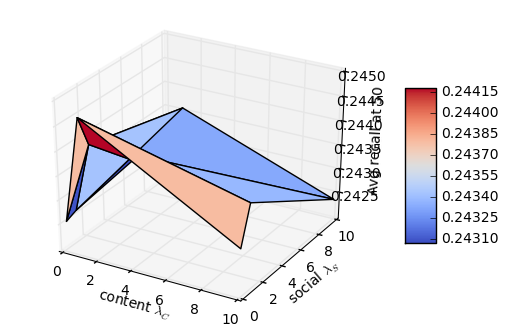

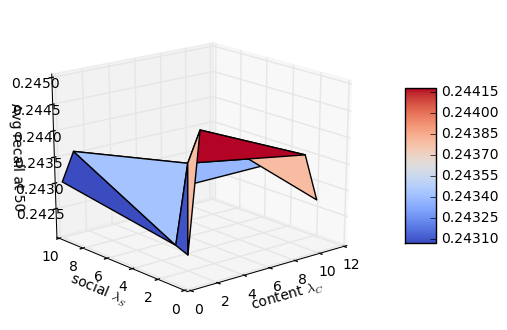

In [66]:
temp_mean = exp11_df_all_mean[exp11_df_all_mean.contw!=100][exp11_df_all_mean.socw!=100]

plot3d_summary_var_contw_socw(temp_mean)
plot3d_summary_var_contw_socw_rotate(temp_mean,angle=230,elev1=20)

In [67]:
exp12_files=!./get_entity_log.sh long_experiment11_fixedk10_constw_varlambda_1dataset773_p85 "##results_file" "#time"
exp12_files=[[x.split("|")[0],float(x.split("|")[0].split('contw')[1].split('_')[0]),\
              float(x.split("|")[0].split('socw')[1].split('_')[0]),\
              int(x.split("|")[1].split(" ")[0])] for x in exp12_files if x.split("|")[1]!='']
exp12_files=pd.DataFrame(exp12_files, columns=['rec','contw','socw','time(s)'])
exp12_summary=genGraphRes_recall_folders(exp12_files.rec.values,is_plot=False,log_print=False)

In [68]:
exp12_df_all=pivot_n_table_var_contw_socw(exp12_summary)

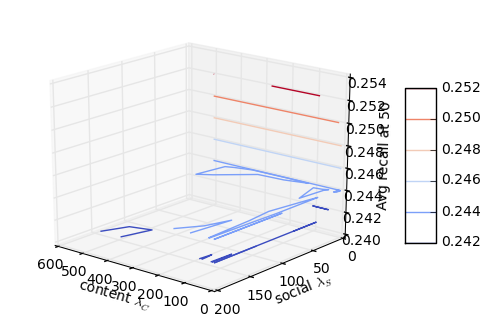

In [69]:
#plot3d_summary_var_contw_socw(exp12_df_all[exp12_df_all.socw<10][exp12_df_all.contw<1000])
anglex=130
#plot3d_summary_var_contw_socw_rotate(exp12_df_all,angle=anglex,elev1=20,\
#                                    fname="plot3d_e11_k10_varwcsc_dataset773_p85_angle"+str(anglex)+".pdf")
#plot3dscatter_summary_var_contw_socw_rotate(exp12_df_all,angle=anglex,elev1=20,\
#                                    fname="plot3d_scatter_e11_k10_varwcsc_dataset773_p85_angle"+str(anglex)+".pdf")

plot3dcontour_summary_var_contw_socw_rotate(exp12_df_all,angle=anglex,elev1=20,\
                                    fname="plot3d_contour_e11_k10_varwcsc_dataset773_p85_angle"+str(anglex)+".pdf")


In [ ]:
exp12_df_all['contw']

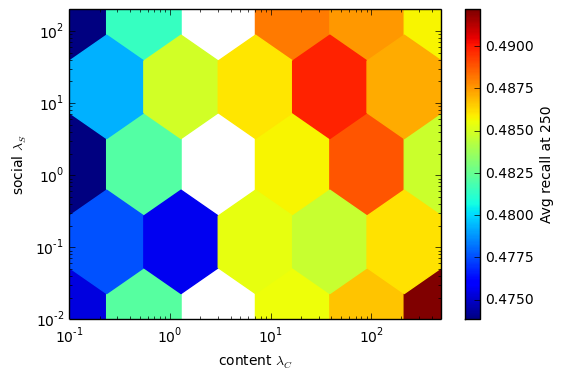

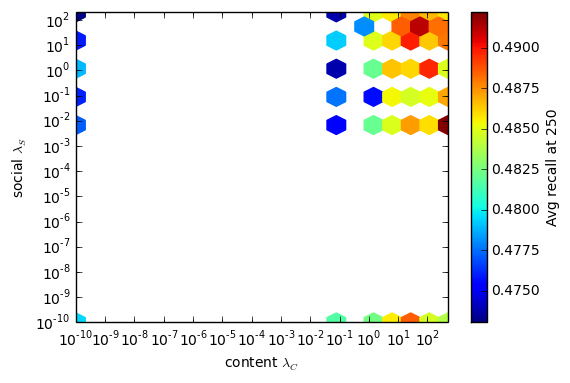

In [70]:



#X=exp12_df_all.contw.values.astype(float)+0.00000001
#Y=exp12_df_all.socw.values.astype(float)+0.00000001
#Z=exp12_df_all[250].values
plothexbin_summary_var_contw_socw(exp12_df_all[exp12_df_all.contw>=0.000000001][exp12_df_all.socw>=0.000000001],\
                                 gridsize=5)

plothexbin_summary_var_contw_socw(exp12_df_all,\
                                 gridsize=20)

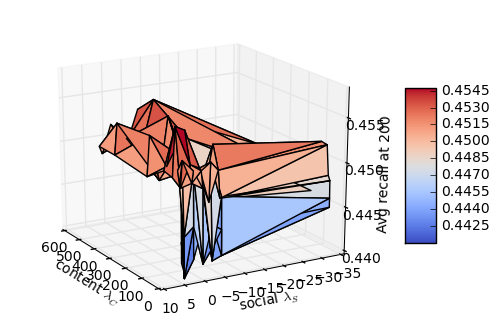

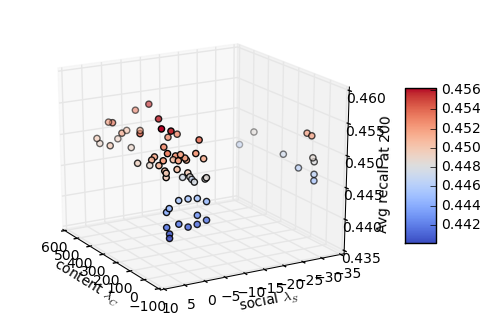

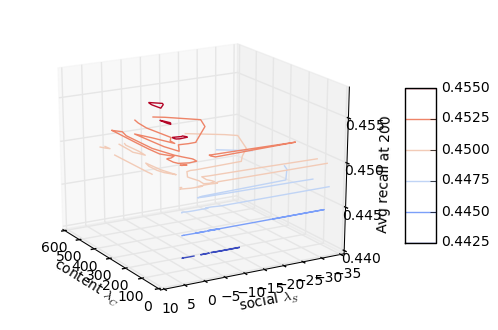

In [71]:
anglex=150
m=200
temp = exp12_df_all[exp12_df_all.socw<100000000000].copy()
temp.socw = np.log(temp.socw+0.00000000000001)
#temp.contw = np.log(temp.contw+0.00000000000001)
plot3d_summary_var_contw_socw_rotate(temp,m=m,angle=anglex,elev1=20)
plot3dscatter_summary_var_contw_socw_rotate(temp,m=m,angle=anglex,elev1=20)
plot3dcontour_summary_var_contw_socw_rotate(temp,m=m,angle=anglex,elev1=20)


#from scipy.interpolate import griddata

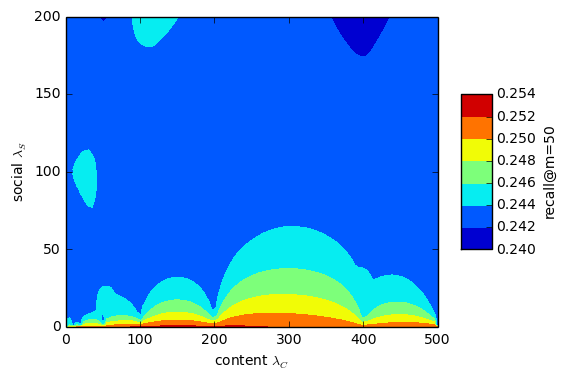

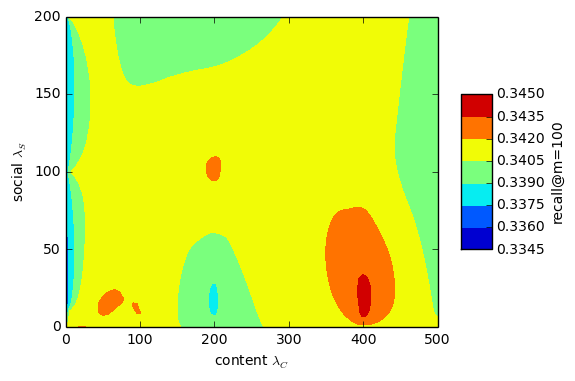

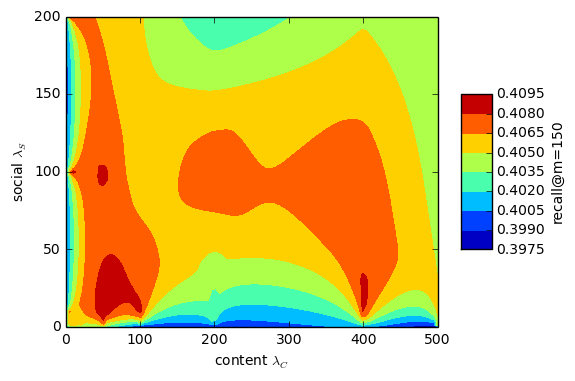

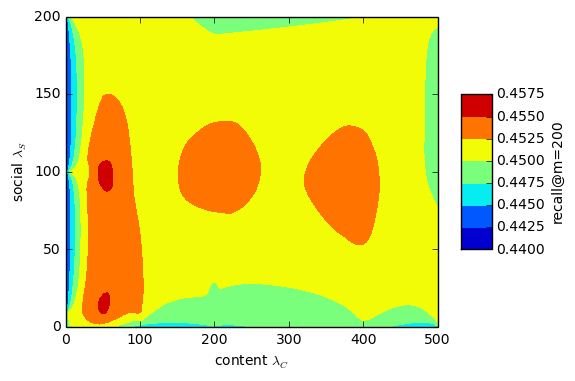

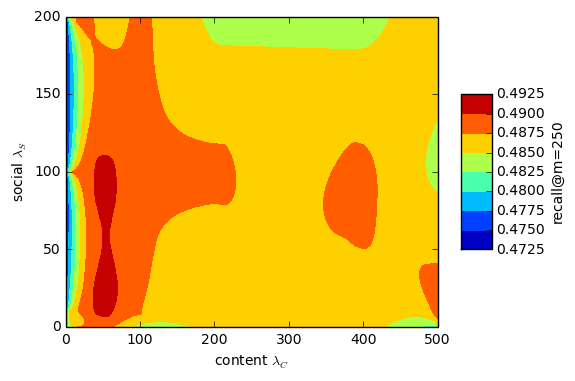

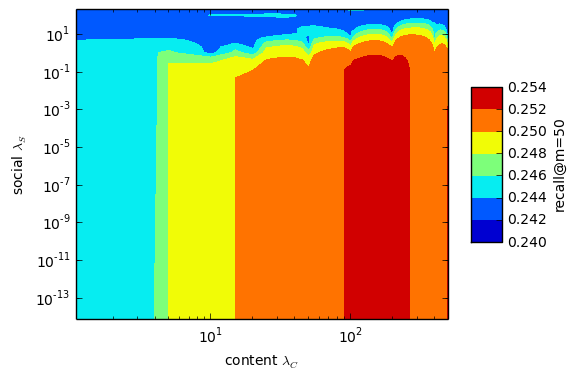

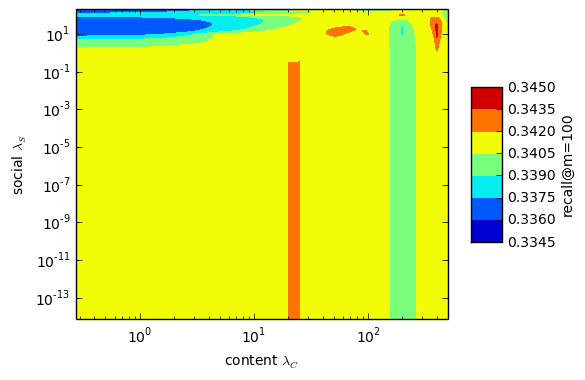

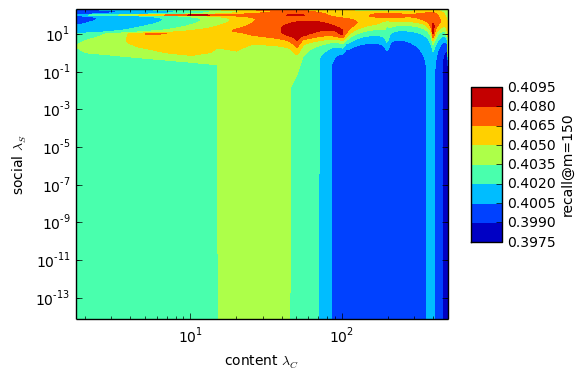

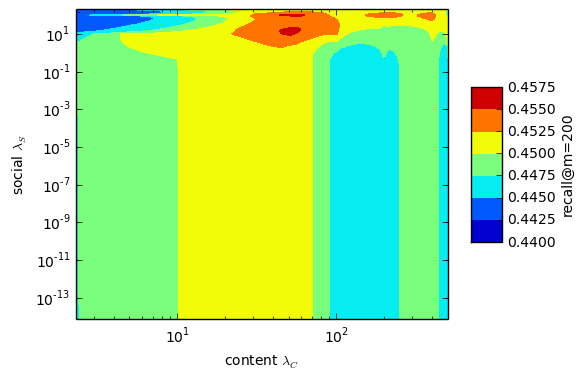

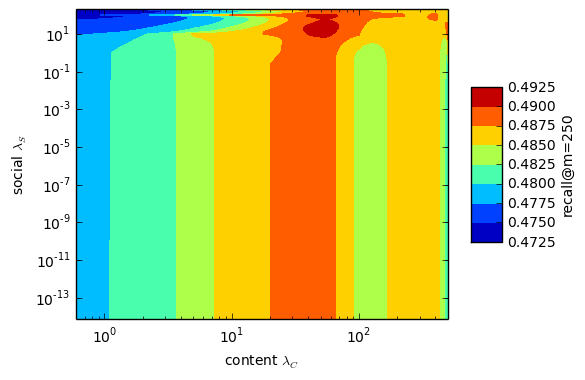

In [72]:
from matplotlib.mlab import griddata

def plot2dcontour_summary_var_contw_socw_rotate(temp_mean,log_xy=False,m=50,fname=None):
    x=temp_mean.contw.values.astype(float)
    y=temp_mean.socw.values.astype(float)
    z=temp_mean[m].values

    fig=plt.figure()
    ax=plt.subplot()
    xi=np.linspace(np.min(x),np.max(x),100)
    yi=np.linspace(np.min(y),np.max(y),200)
    X,Y= np.meshgrid(xi,yi)
    #Z = griddata((x, y), z, (X, Y),method='nearest')
    Z = griddata(x, y, z, X, Y)
    surf=plt.contourf(X,Y,Z)
    cbar=fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.set_label("recall@m="+str(m))
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    if(log_xy):
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
temp = exp12_df_all
#temp.contw = np.log(temp.contw+0.00000000000001)
xy_log=False
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=50,\
                                           fname="plot2d_contour_e11_k10_m50_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=100,\
                                           fname="plot2d_contour_e11_k10_m100_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=150,\
                                           fname="plot2d_contour_e11_k10_m150_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=200,\
                                           fname="plot2d_contour_e11_k10_m200_varlambda_dataset773_p85.pdf")

plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=250,\
                                            fname="plot2d_contour_e11_k10_m250_varlambda_dataset773_p85.pdf")

xy_log=True
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=50,\
                                           fname="plot2d_logxy_contour_e11_k10_m50_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=100,\
                                           fname="plot2d_logxy_contour_e11_k10_m100_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=150,\
                                           fname="plot2d_logxy_contour_e11_k10_m150_varlambda_dataset773_p85.pdf")
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=200,\
                                           fname="plot2d_logxy_contour_e11_k10_m200_varlambda_dataset773_p85.pdf")

plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=250,\
                                            fname="plot2d_logxy_contour_e11_k10_m250_varlambda_dataset773_p85.pdf")

In [73]:
matplotlib.rc('text', usetex=True)

In [74]:
import json
exp13_files=!./get_entity_log.sh long_hyperexperiment1_fixedk15_learnw_varhyper_5datasets_p85 "##results_file" "#end_all"
exp13_files2=!./get_entity_log.sh long_hyperexperiment1_fixedk15_learnw_varhyper_5datasets_p85 "##results_file" "#weight-report"

exp13_initdata=pd.DataFrame(\
                            [dict([('rec',x.split("|")[0])]+zip(['a','b']\
                            ,[float(y) for y in x.split("|")[1].split()[-2:]])+\
                            json.loads(exp13_files2[i].split("|")[1].replace('#weight-report : ','')).items()+\
                            recall_folders_single(x.split("|")[0],log_print=False))for i,x in enumerate(exp13_files)])
##exp13_initdata[[x for x in exp13_initdata.columns if x.startswith('recall_m')]]=exp13_initdata[[x for x in exp13_initdata.columns if x.startswith('recall_m')]].apply(lambda x:[y[0] for y in x])

In [75]:
# convert recall values for [x] to x
exp13_initdata[[x for x in exp13_initdata.columns if x.startswith('recall_m')]]=exp13_initdata[[x for x in exp13_initdata.columns if x.startswith('recall_m')]].apply(lambda x:[y[0] for y in x])

In [76]:
exp13_initdata.to_csv('long_hyperpar_exp1_fixedk15_learnw_varhyper_5datasets_p85.csv',sep='\t')
exp13_initdata.columns

Index([u'a', u'b', u'content_weight', u'init_content_weight', u'init_social_weight', u'isLearn', u'k_latent_dim', u'n_iterations', u'nrec', u'precision_zero', u'rec', u'recall_m100', u'recall_m150', u'recall_m200', u'recall_m250', u'recall_m50', u'social_weight'], dtype='object')

In [77]:
std_exp13=exp13_initdata.groupby(['a','b']).std().reset_index()[['a','b']+[x for x in exp13_initdata.columns if x.startswith('recall')]]
means_exp13=exp13_initdata.groupby(['a','b']).mean().reset_index()[['a','b']+[x for x in exp13_initdata.columns if x.startswith('recall')]]


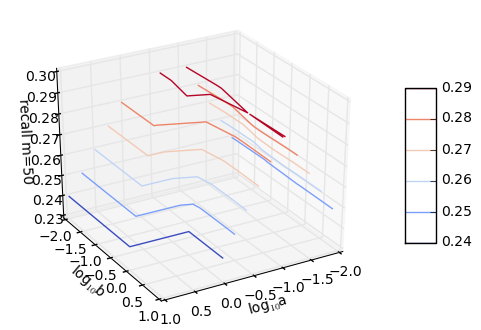

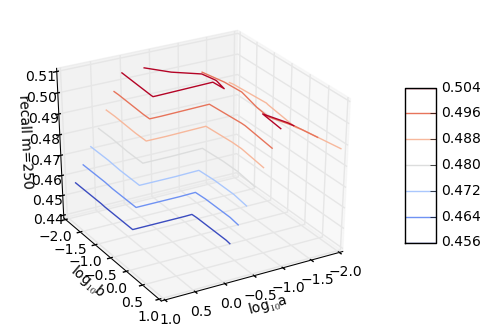

In [79]:
matplotlib.rc('text', usetex=False)
#matplotlib.rc('text', usetex=True)

def plot3d_summary_cols_rotate(temp_mean,cols,angle=250,elev1=6,labels=None,fname=None):
    if(labels==None):
        labels=cols
    X=np.log(temp_mean[cols[0]].values.astype(float))/np.log(10)
    Y=np.log(temp_mean[cols[1]].values.astype(float))/np.log(10)
    #X=temp_mean[cols[0]].values.astype(float)
    #Y=temp_mean[cols[1]].values.astype(float)
    Z=temp_mean[cols[2]].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    surf=ax.tricontour(X,Y,Z,cmap=cm.coolwarm)
    #surf=ax.plot_trisurf(X,Y,Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    #ax.axes.set_xticklabels(list(temp_mean[cols[0]].values.astype(str)))
    #ax.axes.set_yticklabels(list(temp_mean[cols[1]].values.astype(str)))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    return ax

def plot2d_summary_cols_rotate(temp_mean,cols,log_xy=False,labels=None,fname=None):
    if(labels==None):
        labels=cols

    x=temp_mean[cols[0]].values.astype(float)
    y=temp_mean[cols[1]].values.astype(float)

    z=temp_mean[cols[2]].values
    fig = plt.figure()
    ax=plt.subplot()
    xi=np.linspace(np.min(x),np.max(x),200)
    yi=np.linspace(np.min(y),np.max(y),200)
    X,Y= np.meshgrid(xi,yi)
    Z = griddata(x, y, z, X, Y)
    surf=plt.contourf(X,Y,Z)
    cbar=fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.set_label(labels[2])
    if(log_xy):
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    #ax.set_zlabel(labels[2])
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

#plot3dscatter_summary_rotate(means_exp13,['a','b','recall_m50'],angle=50,elev1=6)
#plot3dscatter_summary_rotate(means_exp13,['a','b','recall_m100'],angle=50,elev1=6)
#plot3dscatter_summary_rotate(means_exp13,['a','b','recall_m150'],angle=50,elev1=6)
ax=plot3d_summary_cols_rotate(means_exp13,['a','b','recall_m50'],60,30,['log$_{10}$a','log$_{10}$b','recall m=50'],"hyperparam_exp13_effect_mean_m50.png")


ax=plot3d_summary_cols_rotate(means_exp13,['a','b','recall_m250'],60,30,['log$_{10}$a','log$_{10}$b','recall m=250'],"hyperparam_exp13_effect_mean_m250.png")




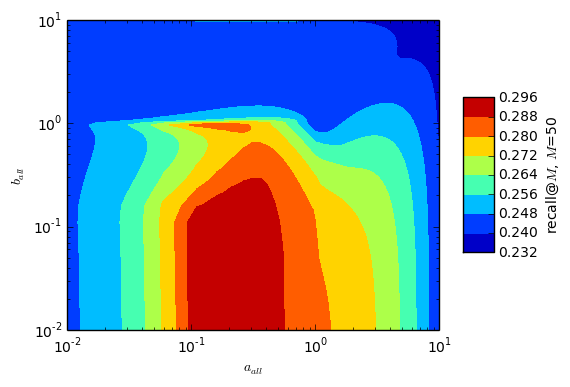

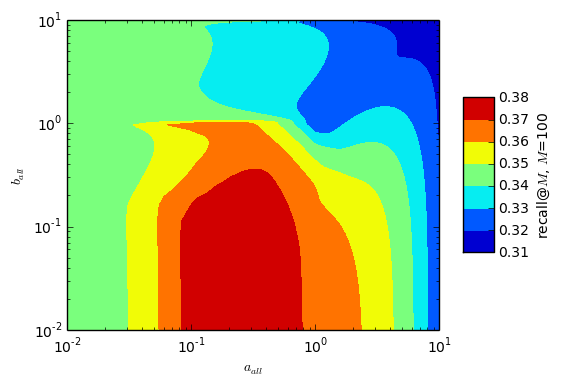

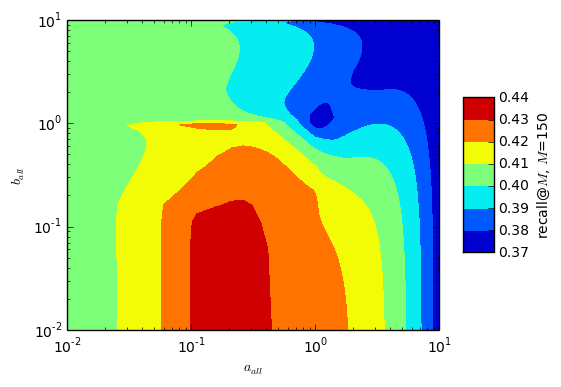

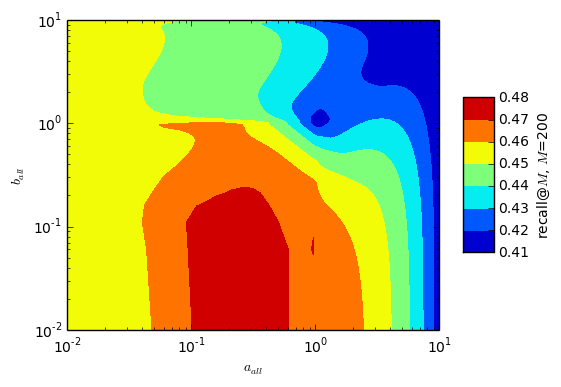

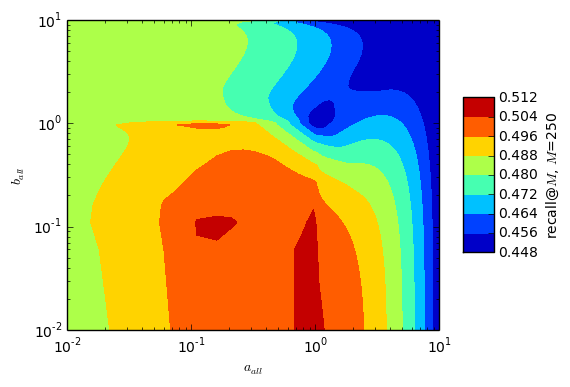

In [90]:
plot2d_summary_cols_rotate(means_exp13,['a','b','recall_m50'],log_xy=True,\
                           labels=['$a_{all}$','$b_{all}$','recall@$M$, $M$=50']\
                           ,fname="hyperparam_exp13_effect_mean_m50_2dcontour.pdf")

plot2d_summary_cols_rotate(means_exp13,['a','b','recall_m100'],log_xy=True,\
                           labels=['$a_{all}$','$b_{all}$','recall@$M$, $M$=100']\
                           ,fname="hyperparam_exp13_effect_mean_m100_2dcontour.pdf")

plot2d_summary_cols_rotate(means_exp13,['a','b','recall_m150'],log_xy=True,\
                           labels=['$a_{all}$','$b_{all}$','recall@$M$, $M$=150']\
                           ,fname="hyperparam_exp13_effect_mean_m150_2dcontour.pdf")

plot2d_summary_cols_rotate(means_exp13,['a','b','recall_m200'],log_xy=True,\
                           labels=['$a_{all}$','$b_{all}$','recall@$M$, $M$=200']\
                           ,fname="hyperparam_exp13_effect_mean_m200_2dcontour.pdf")

plot2d_summary_cols_rotate(means_exp13,['a','b','recall_m250'],log_xy=True,\
                           labels=['$a_{all}$','$b_{all}$','recall@$M$, $M$=250']\
                           ,fname="hyperparam_exp13_effect_mean_m250_2dcontour.pdf")

In [81]:
means_exp13[['a','b','recall_m250']]

,a,b,recall_m250
0,0.01,0.01,0.485862
1,0.01,0.10,0.486940
2,0.01,1.00,0.485222
3,0.01,10.00,0.487871
4,0.10,0.01,0.502058
5,0.10,0.10,0.505015
6,0.10,1.00,0.501839
7,0.10,10.00,0.507166
8,1.00,0.01,0.505091
9,1.00,0.10,0.507407


In [82]:
def pivot_n_table_varhyper(exp11_summary,exp11_files_table):
    exp11_df_all = pd.DataFrame()
    for key in exp11_summary.keys():
        #temp0=exp11_summary[key]
        #temp0['m']=['m='+str(x) for x in temp0['m']]
        temp=exp11_summary[key].pivot_table(columns='m')
        temp.index=[key]
        temp['contw']=[float(key.split('contw')[1].split('_')[0])]
        temp['socw']=[float(key.split('socw')[1].split('_')[0])]
        exp11_df_all=exp11_df_all.append(temp)
    return exp11_df_all

<matplotlib.colorbar.Colorbar instance at 0x7ff09e6c2098>

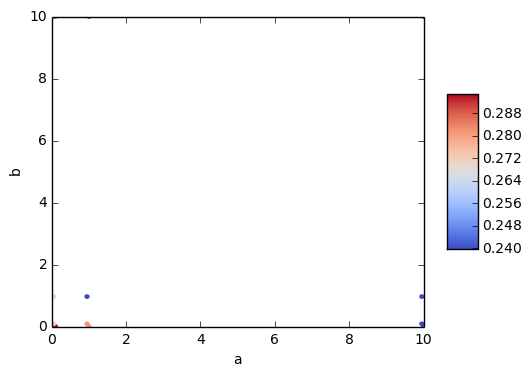

In [83]:
fig = plt.figure()
X=exp13_initdata[['a','b','recall_m50']].a
Y=exp13_initdata[['a','b','recall_m50']].b
Z=exp13_initdata[['a','b','recall_m50']].recall_m50
ax = fig.add_subplot(111)
#ax.set_xscale('log')
surf=ax.hexbin(X,Y,Z,cmap=cm.coolwarm)
#ax.view_init(elev=10, azim=30)
ax.set_xlabel('a')
ax.set_ylabel('b')
#ax.set_zlabel('Avg recall at '+str(50))
    
fig.colorbar(surf, shrink=0.5, aspect=5)

In [94]:
exp14_files=!./get_entity_log.sh exp13_k10_zerow.log "##results_file" "#time"
exp14_files=[[x.split("|")[0],float(x.split("|")[0].split('contw')[1].split('_')[0]),\
              float(x.split("|")[0].split('socw')[1].split('_')[0]),\
              int(x.split("|")[1].split(" ")[0])] for x in exp14_files if x.split("|")[1]!='']
exp14_files=pd.DataFrame(exp14_files, columns=['rec','contw','socw','time(s)'])
exp14_summary=genGraphRes_recall_folders(exp14_files.rec.values,is_plot=False,log_print=False)

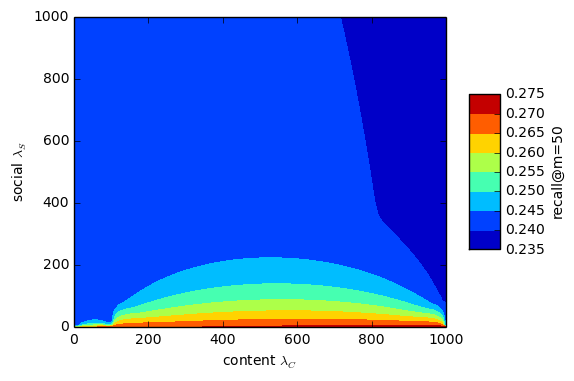

In [223]:
exp14_df_all=pivot_n_table_var_contw_socw(exp14_summary)
means_exp14=exp14_df_all.groupby(['socw','contw']).mean().reset_index()[['socw','contw']+[x for x in exp14_df_all.columns if x not in ['socw','contw']]]


xy_log=False
temp = means_exp14
plot2dcontour_summary_var_contw_socw_rotate(temp,log_xy=xy_log,m=50)

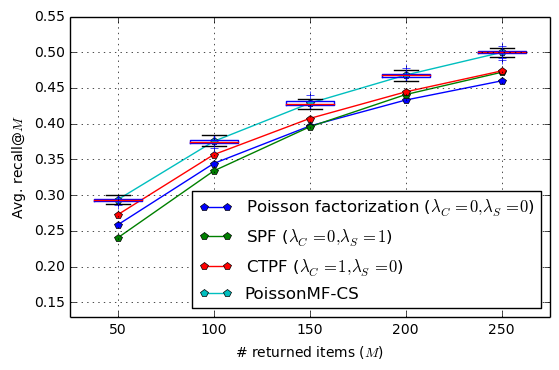

In [226]:
plt.figure()

m_vec=exp14_summary.values()[0].m
#r_vec=

temp=pd.DataFrame(m_vec,columns=['m'])
temp['Poisson factorization ($\lambda_C=0,\lambda_S=0$)']=means_exp14[means_exp14.socw==0][means_exp14.contw==0][\
    [x for x in means_exp14.columns if x not in ['socw','contw']]].values[0]
temp['SPF ($\lambda_C=0,\lambda_S=1$)']=means_exp14[means_exp14.socw==1][means_exp14.contw==0][\
    [x for x in means_exp14.columns if x not in ['socw','contw']]].values[0]
temp['CTPF ($\lambda_C=1,\lambda_S=0$)']=means_exp14[means_exp14.socw==0][means_exp14.contw==1][\
    [x for x in means_exp14.columns if x not in ['socw','contw']]].values[0]

#plot(linestyle='-', marker='p')
temp=temp[['Poisson factorization ($\lambda_C=0,\lambda_S=0$)','SPF ($\lambda_C=0,\lambda_S=1$)',\
           'CTPF ($\lambda_C=1,\lambda_S=0$)']]
temp['PoissonMF-CS']=data_cmp8['PoissonMF-CS']

temp.index=data_cmp8.index+1
axs=temp.plot(linestyle='-', marker='p')

temp2=data_cmp8[[x for x in data_cmp8.columns if x.startswith('k10')]]
temp2['m']=data_cmp8['m']
x=temp2.pivot_table(cols=['m']).boxplot(ax=axs)
axs.set_xlabel('# returned items ($M$)')
axs.set_ylabel('Avg. recall@$M$')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,.13,.55))
plt.savefig("plotcmp_poisson_learn_const_k10.pdf",bbox_inches='tight')

In [189]:
exp14_files.rec[0]

'/home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/lastfm/p85_train_test_2426/experiment_wconst_k10_it40_tol5_contw0.00_socw0.00_nrec1000_ha0.10_hb0.10.rec'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

# Create a dataset with many short random walks
df=exp13_initdata[['a','b','recall_m50']]
#df = pd.DataFrame(np.c_[pos.flat, step, walk],
#                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="a", hue="b", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "b", "recall_m50", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")

# Generate a random dataset with strong simple effects and an interaction
df=exp13_initdata[['a','b','recall_m50']]


# Show a scatterplot of the predictors with the estimated model surface
sns.interactplot("a", "b","recall_m50", df,logy=True,logx=True)

plt.figure()
sns.interactplot('contw','socw',50,exp12_df_all[['contw','socw',50]])

In [112]:
exp14_df_all.columns

Index([50.0, 100.0, 150.0, 200.0, 250.0, u'contw', u'socw'], dtype='object')